In [1]:
import os
import json
import xml.etree.ElementTree as ET
from PIL import Image

# Define categories
CELL_TYPES = ["Epithelial", "Lymphocyte", "Neutrophil", "Macrophage"]
CATEGORY_ID_MAP = {name: i+1 for i, name in enumerate(CELL_TYPES)}  # COCO starts IDs from 1

def get_polygon_bbox_area(points):
    # Compute bbox and area from polygon points
    x_coords = points[::2]
    y_coords = points[1::2]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    
    # Shoelace formula for area
    area = 0.5 * abs(sum(x_coords[i] * y_coords[i+1] - x_coords[i+1] * y_coords[i]
                         for i in range(-1, len(points)//2 - 1)))
    return bbox, area

def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    anns = []

    for annotation in root.findall('Annotation'):
        attr = annotation.find('./Attributes/Attribute')
        if attr is None:
            continue
        label = attr.attrib.get('Name')
        if label not in CATEGORY_ID_MAP:
            continue

        regions = annotation.find('Regions')
        if regions is None:
            continue

        for region in regions.findall('Region'):
            vertices = region.find('Vertices')
            if vertices is None:
                continue

            points = []
            for v in vertices.findall('Vertex'):
                x = float(v.attrib['X'])
                y = float(v.attrib['Y'])
                points.extend([x, y])

            if len(points) >= 6:  # At least 3 points to form polygon
                anns.append({
                    "label": label,
                    "segmentation": [points]
                })

    return anns

def generate_coco(image_dir, output_path):
    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": CATEGORY_ID_MAP[name], "name": name} for name in CELL_TYPES]
    }

    ann_id = 1
    img_id = 1

    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        for file in os.listdir(folder_path):
            if file.endswith('.tif'):
                image_path = os.path.join(folder_path, file)
                xml_path = os.path.splitext(image_path)[0] + ".xml"
                if not os.path.exists(xml_path):
                    continue

                # Load image size
                with Image.open(image_path) as img:
                    width, height = img.size

                coco["images"].append({
                    "id": img_id,
                    "file_name": os.path.relpath(image_path, image_dir).replace("\\", "/"),
                    "width": width,
                    "height": height
                })

                anns = parse_annotation(xml_path)
                for ann in anns:
                    bbox, area = get_polygon_bbox_area(ann["segmentation"][0])
                    coco["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": CATEGORY_ID_MAP[ann["label"]],
                        "segmentation": ann["segmentation"],
                        "bbox": bbox,
                        "area": area,
                        "iscrowd": 0
                    })
                    ann_id += 1

                img_id += 1

    with open(output_path, 'w') as f:
        json.dump(coco, f, indent=2)
    print(f"COCO JSON saved to: {output_path}")

# Example usage
generate_coco("E:/CourseWork/CAP6545/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations", "monusac_coco.json")


COCO JSON saved to: monusac_coco.json


In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
image_root = "E:/CourseWork/CAP6545/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations"        # root folder with patient subfolders
register_coco_instances(
    "monusac_coco_train",
    {},
    "C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco.json",
    "E:/CourseWork/CAP6545/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations"
)

MetadataCatalog.get("monusac_coco_train").thing_classes = ["Epithelial", "Lymphocyte", "Neutrophil", "Macrophage"]


In [3]:
import json

with open("monusac_coco.json") as f:
    coco = json.load(f)

print(f"Images: {len(coco['images'])}")
print(f"Annotations: {len(coco['annotations'])}")
print("Categories:", [cat['name'] for cat in coco['categories']])


Images: 209
Annotations: 31411
Categories: ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']


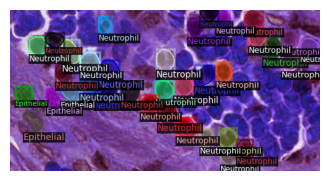

In [5]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

# Load the dataset dicts
dataset_dicts = DatasetCatalog.get("monusac_coco_train")
metadata = MetadataCatalog.get("monusac_coco_train")

# Display a random sample
sample = random.choice(dataset_dicts)
img = cv2.imread(os.path.join(image_root, sample["file_name"]))
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(sample)

# Show using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()


In [6]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger

setup_logger()

# Update with your dataset registration name and paths
TRAIN_DATASET_NAME = "monusac_coco_train"
#VAL_DATASET_NAME = "monusac_val_coco"  # optional
OUTPUT_DIR = "./output_monusac"

cfg = get_cfg()

# Load a base config from Detectron2's model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set dataset
cfg.DATASETS.TRAIN = (TRAIN_DATASET_NAME,)
cfg.DATASETS.TEST = ()

# Dataloader settings
cfg.DATALOADER.NUM_WORKERS = 2

# Pretrained weights from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Training batch size
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000  # adjust depending on your dataset size
cfg.SOLVER.STEPS = []  # No learning rate decay

# Number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES =4

# Inference batch size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Output directory
cfg.OUTPUT_DIR = OUTPUT_DIR
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/23 12:26:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[04/23 12:27:00 d2.engine.train_loop]: Starting training from iteration 0


C:\ProgramData\anaconda3\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/23 12:27:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x00000197C9260D60> to CPU due to CUDA OOM
[04/23 12:27:18 d2.utils.events]:  eta: 0:15:23  iter: 19  total_loss: 5.856  loss_cls: 1.545  loss_box_reg: 0.4688  loss_mask: 0.696  loss_rpn_cls: 2.852  loss_rpn_loc: 0.2771    time: 0.6887  last_time: 0.4083  data_time: 0.2336  last_data_time: 0.0017   lr: 4.9953e-06  max_mem: 4595M
[04/23 12:27:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x00000197C9260D60> to CPU due to CUDA OOM
[04/23 12:27:28 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x00000197C9260D60> to CPU due to CUDA OOM
[04/23 12:27:35 d2.utils.events]:  eta: 0:15:15  iter: 39  total_loss: 4.236  loss_cls: 1.475  loss_box_reg: 0.5565  loss_mask: 0.693  loss_rpn_cls: 1.234  loss_rpn_loc: 0.1786    time: 0.7568  last_time: 0.5142  data_time: 0.0045  last_data_time: 0.0009   lr: 9.9902e-06  max_mem: 4595M
[04/23 12:27:43 d2.utils.mem

kill: 6312: No such process


In [14]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir ./output_monusac

Reusing TensorBoard on port 6007 (pid 6312), started 15:43:40 ago. (Use '!kill 6312' to kill it.)

# test coco and registration starts from here

In [15]:
import os
import json
import xml.etree.ElementTree as ET
from PIL import Image

# Define categories
CELL_TYPES = ["Epithelial", "Lymphocyte", "Neutrophil", "Macrophage"]
CATEGORY_ID_MAP = {name: i+1 for i, name in enumerate(CELL_TYPES)}  # COCO starts IDs from 1

def get_polygon_bbox_area(points):
    # Compute bbox and area from polygon points
    x_coords = points[::2]
    y_coords = points[1::2]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    
    # Shoelace formula for area
    area = 0.5 * abs(sum(x_coords[i] * y_coords[i+1] - x_coords[i+1] * y_coords[i]
                         for i in range(-1, len(points)//2 - 1)))
    return bbox, area

def parse_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    anns = []

    for annotation in root.findall('Annotation'):
        attr = annotation.find('./Attributes/Attribute')
        if attr is None:
            continue
        label = attr.attrib.get('Name')
        if label not in CATEGORY_ID_MAP:
            continue

        regions = annotation.find('Regions')
        if regions is None:
            continue

        for region in regions.findall('Region'):
            vertices = region.find('Vertices')
            if vertices is None:
                continue

            points = []
            for v in vertices.findall('Vertex'):
                x = float(v.attrib['X'])
                y = float(v.attrib['Y'])
                points.extend([x, y])

            if len(points) >= 6:  # At least 3 points to form polygon
                anns.append({
                    "label": label,
                    "segmentation": [points]
                })

    return anns

def generate_coco(image_dir, output_path):
    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": CATEGORY_ID_MAP[name], "name": name} for name in CELL_TYPES]
    }

    ann_id = 1
    img_id = 1

    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        for file in os.listdir(folder_path):
            if file.endswith('.tif'):
                image_path = os.path.join(folder_path, file)
                xml_path = os.path.splitext(image_path)[0] + ".xml"
                if not os.path.exists(xml_path):
                    continue

                # Load image size
                with Image.open(image_path) as img:
                    width, height = img.size

                coco["images"].append({
                    "id": img_id,
                    "file_name": os.path.relpath(image_path, image_dir).replace("\\", "/"),
                    "width": width,
                    "height": height
                })

                anns = parse_annotation(xml_path)
                for ann in anns:
                    bbox, area = get_polygon_bbox_area(ann["segmentation"][0])
                    coco["annotations"].append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": CATEGORY_ID_MAP[ann["label"]],
                        "segmentation": ann["segmentation"],
                        "bbox": bbox,
                        "area": area,
                        "iscrowd": 0
                    })
                    ann_id += 1

                img_id += 1

    with open(output_path, 'w') as f:
        json.dump(coco, f, indent=2)
    print(f"COCO JSON saved to: {output_path}")

# Example usage
generate_coco("E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations", "monusac_coco_test.json")


COCO JSON saved to: monusac_coco_test.json


In [16]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
image_root = "E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations"        # root folder with patient subfolders
register_coco_instances(
    "monusac_coco_test",
    {},
    "C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json",
    "E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations"
)

MetadataCatalog.get("monusac_coco_test").thing_classes = ["Epithelial", "Lymphocyte", "Neutrophil", "Macrophage"]


In [17]:
import json

with open("monusac_coco_test.json") as f:
    coco = json.load(f)

print(f"Images: {len(coco['images'])}")
print(f"Annotations: {len(coco['annotations'])}")
print("Categories:", [cat['name'] for cat in coco['categories']])


Images: 85
Annotations: 13784
Categories: ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']


[04/23 12:58:52 d2.data.datasets.coco]: Loaded 85 images in COCO format from C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json


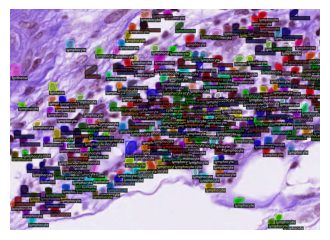

In [18]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

# Load the dataset dicts
dataset_dicts = DatasetCatalog.get("monusac_coco_test")
metadata = MetadataCatalog.get("monusac_coco_test")

# Display a random sample
sample = random.choice(dataset_dicts)
img = cv2.imread(os.path.join(image_root, sample["file_name"]))
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(sample)

# Show using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()


In [19]:
from detectron2.data import DatasetCatalog

test_dataset = DatasetCatalog.get("monusac_coco_test")
print(f"Loaded {len(test_dataset)} test images.")
for d in test_dataset[:3]:
    print(d["file_name"], len(d["annotations"]))


[04/23 12:59:00 d2.data.datasets.coco]: Loaded 85 images in COCO format from C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json
Loaded 85 test images.
E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations\TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_1.tif 7
E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations\TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_2.tif 2
E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations\TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_3.tif 10


In [20]:
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

# Update with your actual dataset names
dataset_name_test = "monusac_coco_test"
json_path_test = "C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json"
image_root_test = "E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations"

# Register test dataset (use same thing_classes as training)
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances

register_coco_instances(dataset_name_test, {}, json_path_test, image_root_test)
MetadataCatalog.get(dataset_name_test).set(thing_classes=['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage'])

# Load trained config
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Your training config file
cfg.MODEL.WEIGHTS = "C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth"  # Final model path
cfg.DATASETS.TEST = (dataset_name_test,)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Lower threshold to get more predictions
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Make sure this matches your training setup

# Run predictor
predictor = DefaultPredictor(cfg)

# Evaluation
evaluator = COCOEvaluator(dataset_name_test, cfg, False, output_dir="./output/test")
val_loader = build_detection_test_loader(cfg, dataset_name_test)
results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(results)


[04/23 13:00:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth ...


C:\Users\14077\AppData\Roaming\Python\Python312\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locatio

[04/23 13:00:57 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [04/23 13:00:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/23 13:00:58 d2.data.datasets.coco]: Loaded 85 images in COCO format from C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json
[04/23 13:00:58 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Epithelial | 6509         | Lymphocyte | 6852         | Neutrophil | 148          |
| Macrophage | 275          |            |              |            |              |
|   total    | 13784        |            |              |            |              |
[04/23 13:00:58 d2.data.dataset_mapper]: [DatasetMapper] A

In [21]:
import os
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from tqdm import tqdm

save_dir = "output/predictions"
os.makedirs(save_dir, exist_ok=True)

for d in tqdm(DatasetCatalog.get("monusac_coco_test")):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("monusac_coco_test"), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    save_path = os.path.join(save_dir, os.path.basename(d["file_name"]))
    cv2.imwrite(save_path, out.get_image()[:, :, ::-1])


[04/23 13:02:13 d2.data.datasets.coco]: Loaded 85 images in COCO format from C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [00:52<00:00,  1.62it/s]


In [24]:
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import inference_on_dataset
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from collections import defaultdict
import os, cv2
import numpy as np

# Set up cfg (make sure it's your test config with correct weights and threshold)
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Your training config file
cfg.MODEL.WEIGHTS = "C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth"  # Final model path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Lower threshold to include more predictions
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # MoNuSAC: change as per your dataset

predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("monusac_coco_test")


json_path_test = "C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json"
image_root_test = "E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations"

# Load test dataset
from detectron2.data.datasets.coco import load_coco_json
dataset_dicts = load_coco_json(json_path_test, image_root_test, "monusac_coco_test")

# Dictionary to store image ID -> list of instance class names
image_instances = {}

for d in dataset_dicts:
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")

    pred_classes = instances.pred_classes.numpy().tolist()
    class_names = [metadata.thing_classes[i] for i in pred_classes]
    image_id = d["image_id"] if "image_id" in d else d["id"]

    image_instances[image_id] = class_names

# Example: print first few entries
for k, v in list(image_instances.items())[:5]:
    print(f"Image ID {k} -> {v}")


[04/23 13:09:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth ...


C:\Users\14077\AppData\Roaming\Python\Python312\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locatio

[04/23 13:09:28 d2.data.datasets.coco]: Loaded 85 images in COCO format from C:/Users/14077/JupyterNotebookFiles/detectron2/monusac_coco_test.json
Image ID 1 -> ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Lymphocyte', 'Lymphocyte', 'Lymphocyte', 'Lymphocyte', 'Macrophage', 'Lymphocyte', 'Lymphocyte', 'Lymphocyte']
Image ID 2 -> ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Macrophage', 'Lymphocyte', 'Macrophage']
Image ID 3 -> ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Lymphocyte', 'Macrophage', 'Lymphocyte', 'Macrophage', 'Macrophage', 'Macrophage', 'Neutrophil', 'Macrophage', 'Macrophage', 'Macrophage', 'Macrophage', 'Lymphocyte', 'Lymphocyte']
Image ID 4 -> ['Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epithelial', 'Epitheli

In [26]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 17.3 MB/s eta 0:00:00


In [27]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import pandas as pd

# Your segmentation results (example structure)
segmentation_results = {
    1: ['Neutrophil', 'Neutrophil', 'Lymphocyte', 'Macrophage'],
    2: ['Neutrophil', 'Lymphocyte'],
    3: ['Epithelial', 'Lymphocyte', 'Neutrophil'],
    # ... (add more entries as per your output)
}

# Step 1: Convert image-wise labels to a list of transactions (remove duplicates within each image)
transactions = [list(set(labels)) for labels in image_instances.values()]

# Step 2: Encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Step 3: Run FP-Growth
frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)

# Sort by support
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print(frequent_itemsets)


     support                                          itemsets
0   0.882353                                      (Lymphocyte)
1   0.541176                                      (Macrophage)
2   0.505882                                      (Neutrophil)
5   0.482353                          (Neutrophil, Macrophage)
4   0.447059                          (Macrophage, Lymphocyte)
3   0.423529                                      (Epithelial)
6   0.423529                          (Neutrophil, Lymphocyte)
7   0.400000              (Neutrophil, Macrophage, Lymphocyte)
8   0.376471                          (Epithelial, Lymphocyte)
9   0.188235                          (Epithelial, Macrophage)
11  0.164706              (Epithelial, Macrophage, Lymphocyte)
10  0.129412                          (Epithelial, Neutrophil)
12  0.129412              (Epithelial, Macrophage, Neutrophil)
13  0.117647              (Epithelial, Neutrophil, Lymphocyte)
14  0.117647  (Epithelial, Macrophage, Neutrophil, Lymp

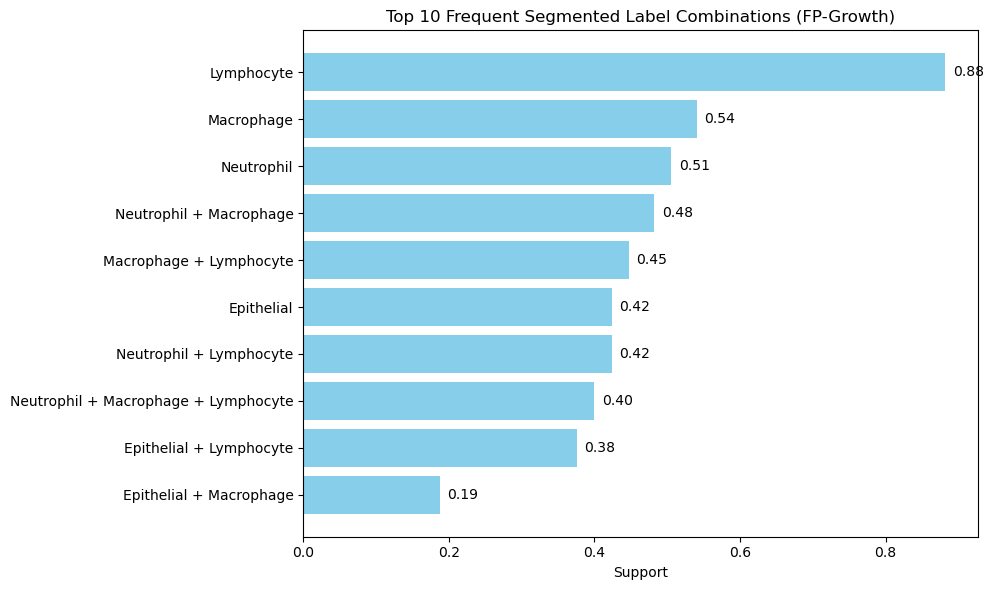

In [28]:
import matplotlib.pyplot as plt

# Plot Top-N frequent itemsets
top_n = 10  # change this as needed
top_itemsets = frequent_itemsets.head(top_n)

# Convert frozensets to string for x-axis
labels = [' + '.join(list(item)) for item in top_itemsets['itemsets']]
support = top_itemsets['support']

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, support, color='skyblue')
plt.xlabel('Support')
plt.title(f'Top {top_n} Frequent Segmented Label Combinations (FP-Growth)')
plt.gca().invert_yaxis()  # Highest at the top

# Optional: Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()


In [43]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
import cv2
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Make sure to use the correct config path and weights
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Your training config file
cfg.MODEL.WEIGHTS = "C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth"  # Final model path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # Set low threshold if needed
predictor = DefaultPredictor(cfg)

# Path to your test images
test_images_dir = "E:/CourseWork/CAP6545/MoNuSAC Testing Data and Annotations/MoNuSAC Testing Data and Annotations"

# Rebuild the mapping: image_id -> list of predicted class names
image_id_to_labels = {}
thing_classes = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes

for idx, fname in enumerate(sorted(os.listdir(test_images_dir))):
    if fname.lower().endswith((".png", ".jpg", ".tif")):
        path = os.path.join(test_images_dir, fname)
        image = cv2.imread(path)
        outputs = predictor(image)
        instances = outputs["instances"]
        class_ids = instances.pred_classes.tolist() if len(instances) else []
        class_names = [thing_classes[i] for i in class_ids]
        image_id_to_labels[idx + 1] = class_names  # assuming image IDs start from 1


[04/23 13:24:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/Users/14077/JupyterNotebookFiles/detectron2/output_monusac/model_final.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (5, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (16, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (16,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (4, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) 

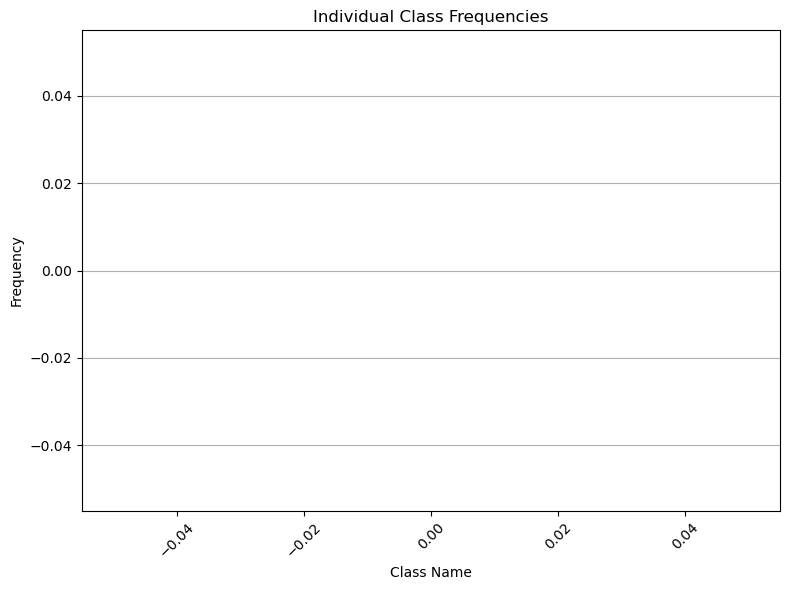

In [44]:
# Flatten all labels into one big list
all_labels = [label for labels in image_id_to_labels.values() for label in labels]

# Count frequencies
label_counts = Counter(all_labels)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='teal')
plt.xlabel("Class Name")
plt.ylabel("Frequency")
plt.title("Individual Class Frequencies")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


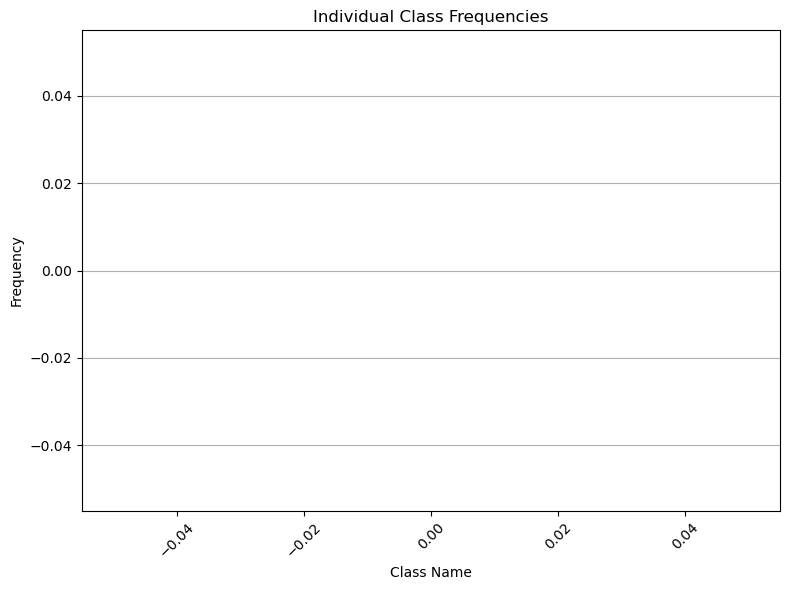

In [45]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all labels from all images
all_labels = [label for labels in image_id_to_labels.values() for label in labels]

# Count how many times each label appears
label_counts = Counter(all_labels)

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel("Class Name")
plt.ylabel("Frequency")
plt.title("Individual Class Frequencies")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [48]:
image_id_to_labels = {
    1: ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Macrophage'],
    2: ['Lymphocyte', 'Macrophage', 'Lymphocyte'],
    3: ['Macrophage', 'Neutrophil']
}

# Flattening the labels
flat_labels = [label for labels in image_id_to_labels.values() for label in labels]

print(flat_labels)
# Output: ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Macrophage', 'Lymphocyte', 'Macrophage', 'Lymphocyte', 'Macrophage', 'Neutrophil']


['Neutrophil', 'Neutrophil', 'Neutrophil', 'Macrophage', 'Lymphocyte', 'Macrophage', 'Lymphocyte', 'Macrophage', 'Neutrophil']


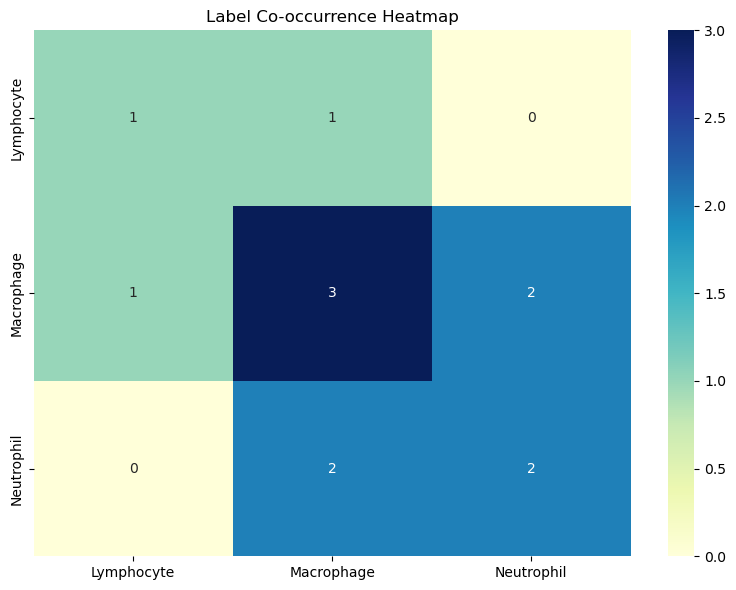

In [49]:
import seaborn as sns
import pandas as pd

# Get all unique labels
all_labels = sorted(set(flat_labels))
label_index = {label: idx for idx, label in enumerate(all_labels)}
co_matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Fill co-occurrence matrix
for labels in image_id_to_labels.values():
    unique = set(labels)
    for l1 in unique:
        for l2 in unique:
            co_matrix.loc[l1, l2] += 1

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Label Co-occurrence Heatmap")
plt.tight_layout()
plt.show()


C:\Users\14077\AppData\Local\Temp\ipykernel_25764\3239441047.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


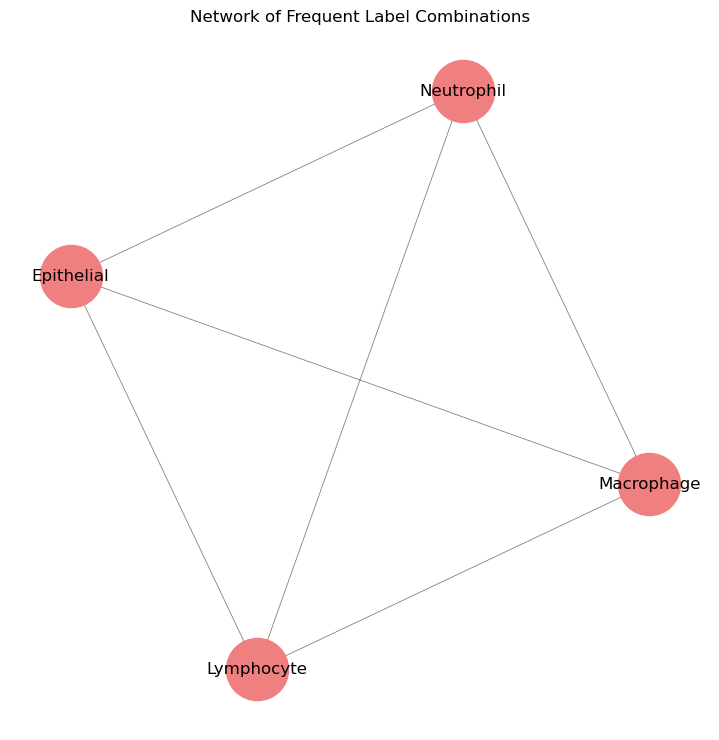

In [47]:
import networkx as nx

G = nx.Graph()

# Add edges for itemsets with more than 1 label
for _, row in frequent_itemsets.iterrows():
    items = list(row['itemsets'])
    if len(items) > 1:
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                G.add_edge(items[i], items[j], weight=row['support'])

# Draw network
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [d['weight'] * 5 for (_, _, d) in edges]

nx.draw(G, pos, with_labels=True, node_color='lightcoral',
        node_size=2000, edge_color='gray', width=weights)
plt.title("Network of Frequent Label Combinations")
plt.tight_layout()
plt.show()
